# ****Importing packages and modules****

In [78]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn .metrics import roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ****Preprocessing Train data****

In [79]:
train_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-bondman/trainData.csv')
train_fraud=train_data['is_fraud']
numerical_cols=[i for i in train_data.columns if train_data[i].dtype in ['int64', 'float64']]
categorical_cols=[i for i in train_data.columns if train_data[i].dtype=="object" ]
print(categorical_cols)
train_data.head()

['trans_date_trans_time', 'merchant', 'category', 'first', 'last', 'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num']


,id,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,1,2019-12-15 10:35:10,3597926034019603,fraud_Ruecker Group,misc_net,7.19,Derrick,Flores,M,83690 Nicholas Ports Apt. 846,...,35.2229,-89.5518,9496,Furniture conservator/restorer,1993-03-23,2642fec2e19c9e18e61fe9a88f6bc79a,1355567710,35.189455,-90.121666,0
1,2,2019-04-10 21:49:53,4873783502705038,fraud_Lynch Ltd,shopping_pos,6.32,Elizabeth,Maxwell,F,194 Goodman Fall Apt. 569,...,48.4786,-122.3345,14871,Public house manager,1974-03-10,61cec15bdbd3db31b12f886e8e181380,1334094593,49.004316,-122.745016,0
2,3,2020-02-16 10:56:18,213161869125933,fraud_Bauch-Raynor,grocery_pos,147.59,Monica,Lane,F,3270 Scott Islands,...,44.6084,-70.6993,190,Animal nutritionist,1970-04-17,c8fcf575540e37ce0822cd040148ff57,1361012178,44.455449,-70.809148,0
3,4,2020-04-30 16:14:16,374656033243756,"fraud_Effertz, Welch and Schowalter",entertainment,32.40,David,Lewis,M,1499 Michael Rue,...,38.8954,-77.1633,207410,Mudlogger,1984-07-03,9e9cde0e0963ac746a2cc9938e171c9a,1367338456,39.476941,-77.613438,0
4,5,2019-12-05 21:07:59,6011999606625827,fraud_Wilkinson LLC,personal_care,29.79,Ronald,Carson,M,870 Rocha Drive,...,40.9918,-73.9800,4664,"Radiographer, diagnostic",1965-06-30,0742473d7f6261ce366b43ece063faf3,1354741679,40.863808,-74.674018,0


In [80]:
train_data.isnull().sum()

id                       0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [81]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523174 entries, 0 to 523173
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     523174 non-null  int64  
 1   trans_date_trans_time  523174 non-null  object 
 2   cc_num                 523174 non-null  int64  
 3   merchant               523174 non-null  object 
 4   category               523174 non-null  object 
 5   amt                    523174 non-null  float64
 6   first                  523174 non-null  object 
 7   last                   523174 non-null  object 
 8   gender                 523174 non-null  object 
 9   street                 523174 non-null  object 
 10  city                   523174 non-null  object 
 11  state                  523174 non-null  object 
 12  zip                    523174 non-null  int64  
 13  lat                    523174 non-null  float64
 14  long                   523174 non-nu

In [82]:
train_data.drop(columns=['id','trans_date_trans_time','cc_num','first','last','street','dob','trans_num'],inplace=True)
train_data.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud
0,fraud_Ruecker Group,misc_net,7.19,M,Oakland,TN,38060,35.2229,-89.5518,9496,Furniture conservator/restorer,1355567710,35.189455,-90.121666,0
1,fraud_Lynch Ltd,shopping_pos,6.32,F,Burlington,WA,98233,48.4786,-122.3345,14871,Public house manager,1334094593,49.004316,-122.745016,0
2,fraud_Bauch-Raynor,grocery_pos,147.59,F,East Andover,ME,4226,44.6084,-70.6993,190,Animal nutritionist,1361012178,44.455449,-70.809148,0
3,"fraud_Effertz, Welch and Schowalter",entertainment,32.40,M,Arlington,VA,22213,38.8954,-77.1633,207410,Mudlogger,1367338456,39.476941,-77.613438,0
4,fraud_Wilkinson LLC,personal_care,29.79,M,Harrington Park,NJ,7640,40.9918,-73.9800,4664,"Radiographer, diagnostic",1354741679,40.863808,-74.674018,0


In [83]:
features=[i for i in train_data.columns if train_data[i].dtype=="object" ]
encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    ).fit(train_data[features])
train_data[features]=encoder.transform(train_data[features])
train_data.head()
train_y=train_data['is_fraud']
train_data.pop('is_fraud')

0         0
1         0
2         0
3         0
4         0
         ..
523169    0
523170    0
523171    0
523172    0
523173    0
Name: is_fraud, Length: 523174, dtype: int64

# ****Training Data Visualization****

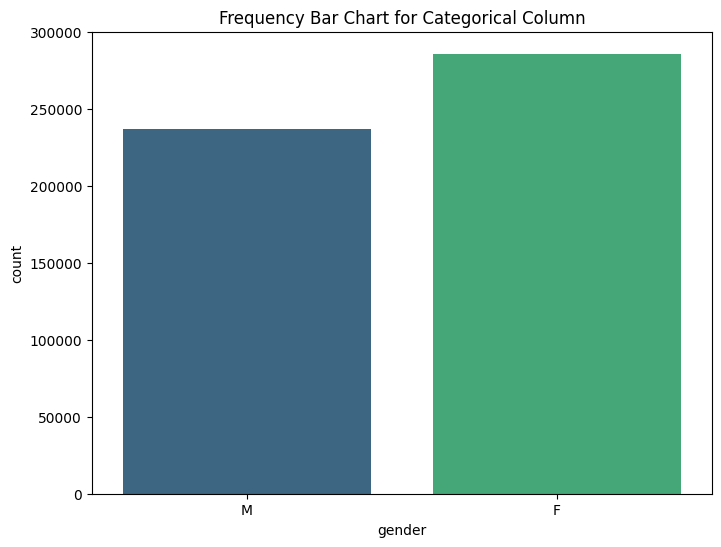

In [84]:
visual_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-bondman/trainData.csv')
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=visual_data, palette='viridis')
plt.title('Frequency Bar Chart for Categorical Column')
plt.show()

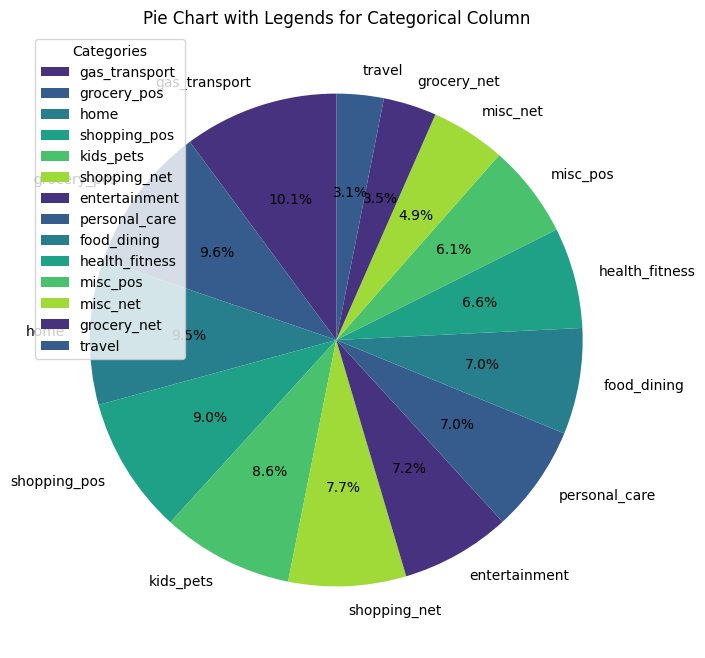

In [85]:
plt.figure(figsize=(8, 8))
plt.pie(visual_data['category'].value_counts().values, labels=visual_data['category'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=visual_data['category'].value_counts().index, loc='best')
plt.show()

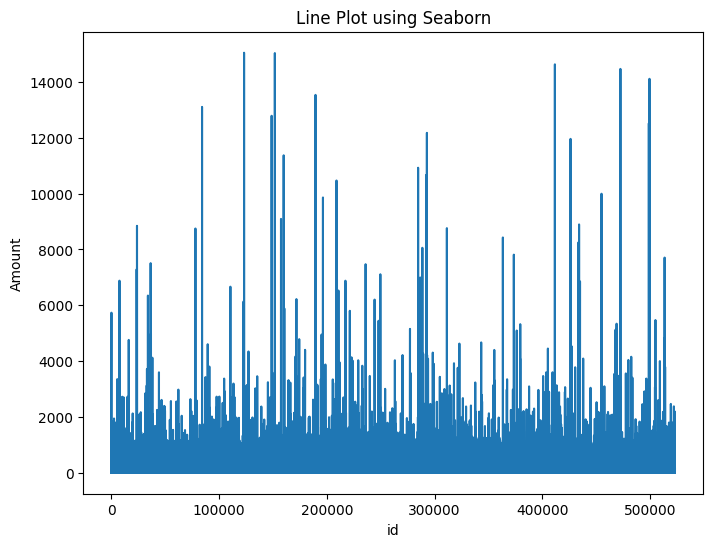

In [86]:
plt.figure(figsize=(8, 6))
plt.plot(visual_data['id'],visual_data['amt'])
plt.title('Line Plot using Seaborn')
plt.xlabel('id')
plt.ylabel('Amount')
plt.show()

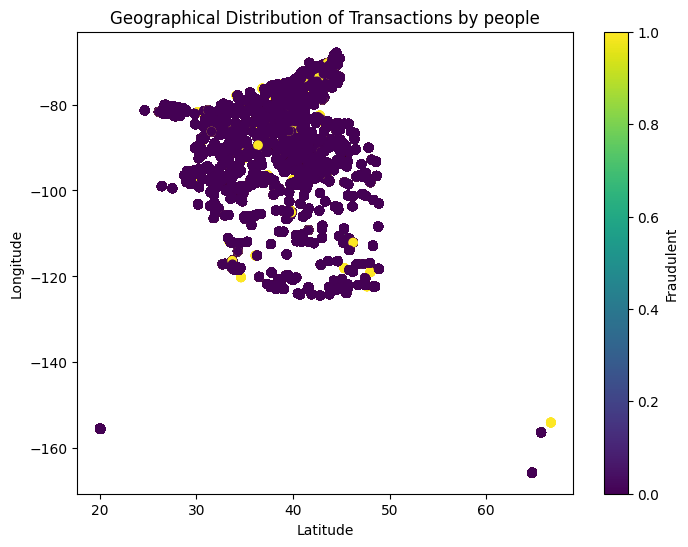

In [87]:
plt.figure(figsize=(8, 6))
plt.scatter(visual_data['lat'], visual_data['long'], c=visual_data['is_fraud'])
plt.title('Geographical Distribution of Transactions by people')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Fraudulent')
plt.show()

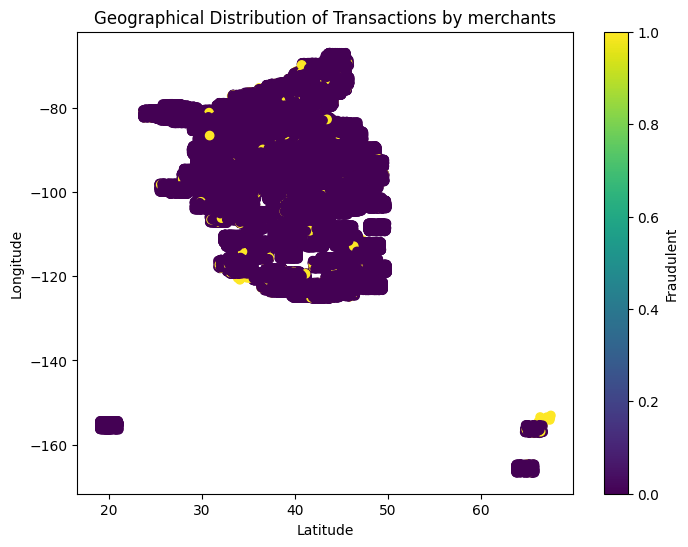

In [88]:
plt.figure(figsize=(8, 6))
plt.scatter(visual_data['merch_lat'], visual_data['merch_long'], c=visual_data['is_fraud'])
plt.title('Geographical Distribution of Transactions by merchants')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Fraudulent')
plt.show()

# ****PreProcessing Test Data****

In [89]:
test_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-bondman/testData.csv')
numerical_cols=[i for i in train_data.columns if train_data[i].dtype in ['int64', 'float64']]
categorical_cols=[i for i in train_data.columns if train_data[i].dtype=="object" ]
print(categorical_cols)
test_data.head()

[]


,id,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long
0,1,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,29209,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714
1,2,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,84002,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431
2,3,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,11710,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111
3,4,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,32780,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061
4,5,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,49632,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734


In [90]:
test_data.isnull().sum()

id                       0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
dtype: int64

In [91]:
test_data.drop(columns=['id','trans_date_trans_time','cc_num','first','last','street','dob','trans_num'],inplace=True)
features=[i for i in test_data.columns if test_data[i].dtype=="object" ]
encoder = OrdinalEncoder(
        handle_unknown='use_encoded_value', 
        unknown_value=-1
    ).fit(test_data[features])
test_data[features]=encoder.transform(test_data[features])
test_data.head()

,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long
0,319.0,10.0,2.86,1.0,157.0,39.0,29209,33.9659,-80.9355,333497,275.0,1371816865,33.986391,-81.200714
1,591.0,10.0,29.84,0.0,16.0,43.0,84002,40.3207,-110.4360,302,392.0,1371816873,39.450498,-109.960431
2,611.0,5.0,41.28,0.0,61.0,33.0,11710,40.6729,-73.5365,34496,259.0,1371816893,40.495810,-74.196111
3,222.0,9.0,60.05,1.0,764.0,8.0,32780,28.5697,-80.8191,54767,407.0,1371816915,28.812398,-80.883061
4,292.0,13.0,3.19,1.0,247.0,21.0,49632,44.2529,-85.0170,1126,196.0,1371816917,44.959148,-85.884734


# ****Data Visualization of Test Data****

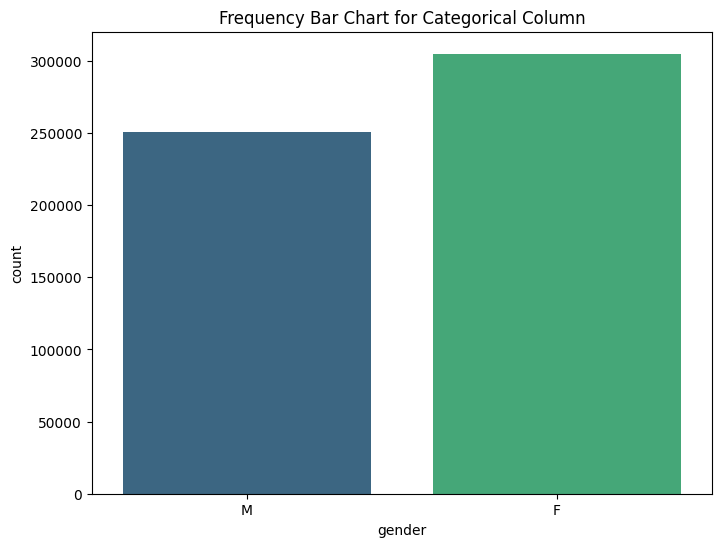

In [92]:
test_visual_data=pd.read_csv('/kaggle/input/anyas-gojo-revival-bondman/testData.csv')
plt.figure(figsize=(8, 6))
sns.countplot(x='gender', data=test_visual_data, palette='viridis')
plt.title('Frequency Bar Chart for Categorical Column')
plt.show()

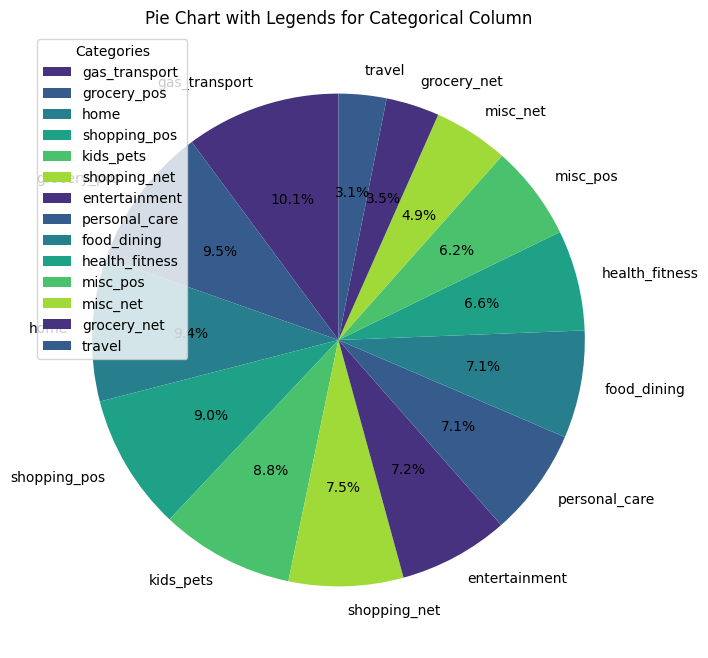

In [93]:
plt.figure(figsize=(8, 8))
plt.pie(test_visual_data['category'].value_counts().values, labels=test_visual_data['category'].value_counts().index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Pie Chart with Legends for Categorical Column')
plt.legend(title='Categories', labels=test_visual_data['category'].value_counts().index, loc='best')
plt.show()

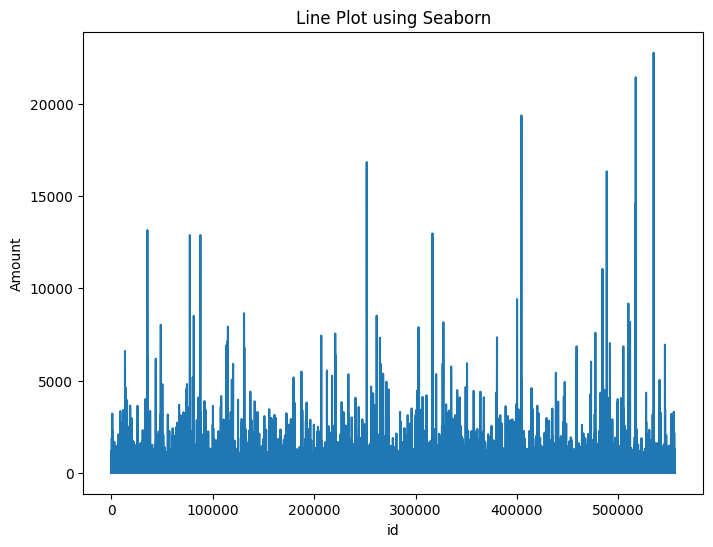

In [94]:
plt.figure(figsize=(8, 6))
plt.plot(test_visual_data['id'],test_visual_data['amt'])
plt.title('Line Plot using Seaborn')
plt.xlabel('id')
plt.ylabel('Amount')
plt.show()

# ****Making of Model and training of model****

In [95]:
X_train, X_test, y_train, y_test = train_test_split(train_data, train_y, test_size=0.1, random_state=42)

In [96]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=14))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(2, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 
sscaler = StandardScaler()
X_train = sscaler.fit_transform(X_train)
model.fit(X_train, y_train, epochs=20, batch_size=50)

Epoch 1/20
9418/9418 [==============================] - 32s 3ms/step - loss: 0.0419 - accuracy: 0.9881
Epoch 2/20
9418/9418 [==============================] - 32s 3ms/step - loss: 0.0327 - accuracy: 0.9914
Epoch 3/20
9418/9418 [==============================] - 31s 3ms/step - loss: 0.0270 - accuracy: 0.9928
Epoch 4/20
9418/9418 [==============================] - 31s 3ms/step - loss: 0.0248 - accuracy: 0.9932
Epoch 5/20
9418/9418 [==============================] - 31s 3ms/step - loss: 0.0240 - accuracy: 0.9934
Epoch 6/20
9418/9418 [==============================] - 30s 3ms/step - loss: 0.0230 - accuracy: 0.9936
Epoch 7/20
9418/9418 [==============================] - 31s 3ms/step - loss: 0.0223 - accuracy: 0.9937
Epoch 8/20
9418/9418 [==============================] - 30s 3ms/step - loss: 0.0218 - accuracy: 0.9937
Epoch 9/20
9418/9418 [==============================] - 32s 3ms/step - loss: 0.0214 - accuracy: 0.9938
Epoch 10/20
9418/9418 [==============================] - 31s 3ms/step - l

In [97]:
X_test = sscaler.fit_transform( X_test)
arr=model.predict(X_test)

1635/1635 [==============================] - 2s 1ms/step


# ****Model Analysis****

In [98]:
arrset=[]
print(arr)
for i in arr:
    if i[0]>0.01:
        arrset.append(1)
    else:
        arrset.append(0)
roc_auc = roc_auc_score(y_test, arrset)
print("The value of roc_auc is "+str(roc_auc))

[[1.2963692e-11]
 [2.8746757e-05]
 [2.0635188e-08]
 ...
 [2.1819767e-08]
 [3.3714587e-11]
 [1.7287270e-03]]
The value of roc_auc is 0.9410706260336408


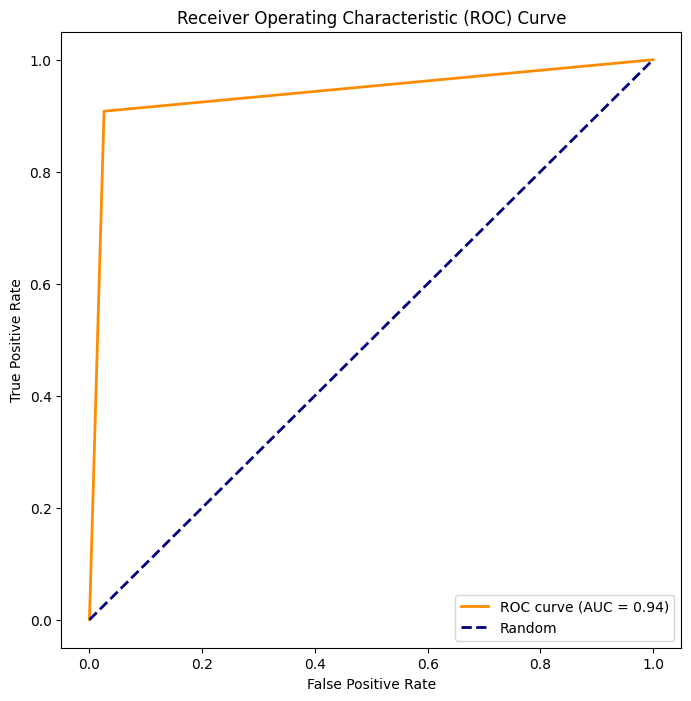

In [99]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, arrset)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# ****Predictions on Test data****

In [100]:
test_data = sscaler.fit_transform(test_data)
arr1=model.predict(test_data)
print(arr1)

17367/17367 [==============================] - 24s 1ms/step
[[3.3277334e-04]
 [1.5287178e-04]
 [3.2785540e-08]
 ...
 [8.9969472e-09]
 [2.8089082e-03]
 [3.8760332e-12]]


In [108]:
sdfg=0
arrset1=[]
roc=[]
print(len(arr1))
for i in arr1:
    if i[0]>0.01:
        arrset1.append(1)
    else:
        arrset1.append(0)
    roc.append(i[0])
    
print(sum(arrset1))

555719
14905


# ****Result Visualzation****

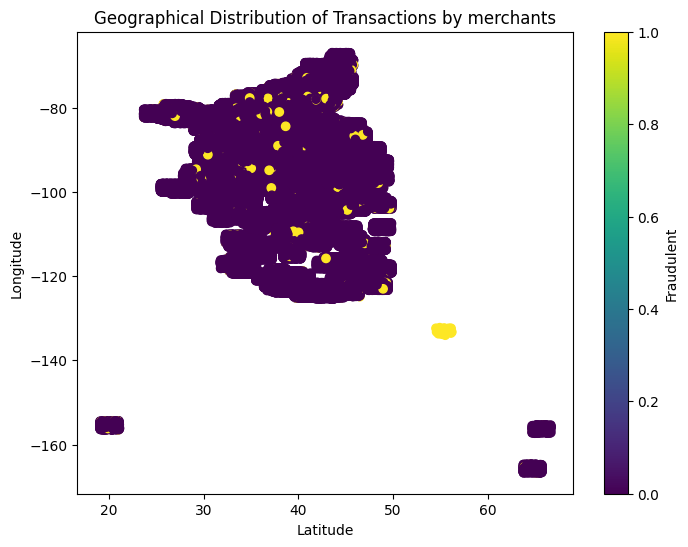

In [109]:
plt.figure(figsize=(8, 6))
plt.scatter(test_visual_data['merch_lat'], test_visual_data['merch_long'], c=arrset1)
plt.title('Geographical Distribution of Transactions by merchants')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Fraudulent')
plt.show()

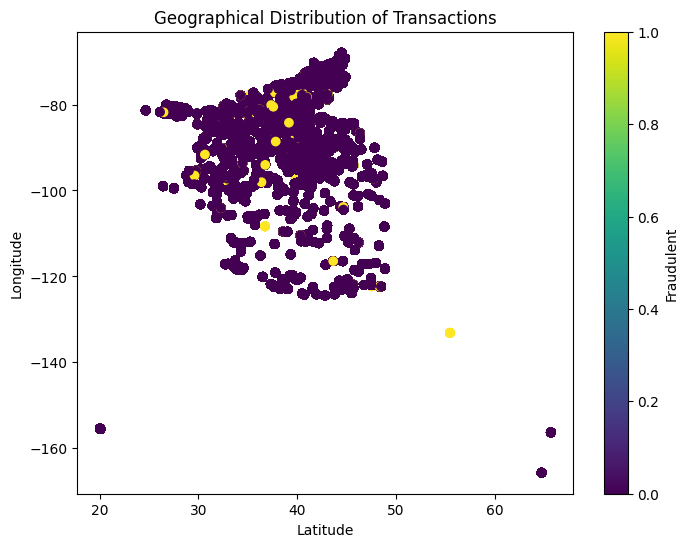

In [110]:
plt.figure(figsize=(8, 6))
plt.scatter(test_visual_data['lat'], test_visual_data['long'], c=arrset1)
plt.title('Geographical Distribution of Transactions')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.colorbar(label='Fraudulent')
plt.show()

In [104]:
sum(arr)

array([594.7443], dtype=float32)

# ****Downloading CSV file****

In [111]:
submission=pd.DataFrame({'id':range(1,len(arr1)+1),'id_fraud':arrset1})
submission.to_csv('submission20.csv', index=False)